#                                               Временные ряды

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.1.-Описание-проекта" data-toc-modified-id="1.1.-Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1.1. Описание проекта</a></span></li><li><span><a href="#1.2.-Описние-данных" data-toc-modified-id="1.2.-Описние-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>1.2. Описние данных</a></span></li><li><span><a href="#3.-Обработка-данных" data-toc-modified-id="3.-Обработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Обработка данных</a></span></li><li><span><a href="#3.1.-Ресемплирование" data-toc-modified-id="3.1.-Ресемплирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>3.1. Ресемплирование</a></span></li><li><span><a href="#3.2.-Предварительный-анализ-данных" data-toc-modified-id="3.2.-Предварительный-анализ-данных-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>3.2. Предварительный анализ данных</a></span></li><li><span><a href="#3.3.-Обработка-данных-и-оценка-результата" data-toc-modified-id="3.3.-Обработка-данных-и-оценка-результата-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>3.3. Обработка данных и оценка результата</a></span></li><li><span><a href="#3.4.-Оценка-трендов-и-сезонности" data-toc-modified-id="3.4.-Оценка-трендов-и-сезонности-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>3.4. Оценка трендов и сезонности</a></span></li><li><span><a href="#3.5.-Генерация-признаков" data-toc-modified-id="3.5.-Генерация-признаков-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>3.5. Генерация признаков</a></span></li><li><span><a href="#4.1.-Линейная-регрессия" data-toc-modified-id="4.1.-Линейная-регрессия-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>4.1. Линейная регрессия</a></span></li><li><span><a href="#4.1.1.-Обучение" data-toc-modified-id="4.1.1.-Обучение-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>4.1.1. Обучение</a></span></li><li><span><a href="#4.1.2.-Прогноз-на-тестовой-выборке" data-toc-modified-id="4.1.2.-Прогноз-на-тестовой-выборке-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>4.1.2. Прогноз на тестовой выборке</a></span></li><li><span><a href="#4.2.-Градиентный-бустинг.-LightGBM" data-toc-modified-id="4.2.-Градиентный-бустинг.-LightGBM-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>4.2. Градиентный бустинг. LightGBM</a></span></li><li><span><a href="#4.2.1.-Обучение" data-toc-modified-id="4.2.1.-Обучение-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>4.2.1. Обучение</a></span></li><li><span><a href="#4.2.2.-Прогноз-на-тестовой-выборке" data-toc-modified-id="4.2.2.-Прогноз-на-тестовой-выборке-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>4.2.2. Прогноз на тестовой выборке</a></span></li><li><span><a href="#5.-Выводы" data-toc-modified-id="5.-Выводы-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>5. Выводы</a></span></li></ul></div>

# 1. Введение
<a id="1"></a>

## 1.1. Описание проекта
<a id="1.1."></a>

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

**Цель:** Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Задача:**  Необходимо построить модель для предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.



## 1.2. Описние данных
<a id="1.2."></a>

Данные лежат в файле /datasets/taxi. Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

# 2. Загрузка данных
<a id="2."></a>

In [1]:
import pandas as pd
import os
import warnings
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
import optuna

In [2]:
path1 = 'taxi.csv'
path2 = '/datasets/taxi.csv'
if os.path.exists(path1):
    df = pd.read_csv(path1)
elif os.path.exists(path2):
    df = pd.read_csv(path2)
else: print('файл не найден')

df['datetime'] = pd.to_datetime(df['datetime'] )
df = df.set_index('datetime')
print('Временной ряд упорядочен:', df.index.is_monotonic)

Временной ряд упорядочен: True


In [3]:
display(df.head())
print(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


## 3. Обработка данных
<a id="3."></a>

## 3.1. Ресемплирование
<a id="3.1."></a>

In [4]:
df_resampled = df.resample('1H').sum()
print('посмотрим на фрагмент данных')
display(df_resampled.head())

посмотрим на фрагмент данных


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## 3.2. Предварительный анализ данных
<a id="3.2."></a>

[Text(0, 0.5, 'Кол-во заказов')]

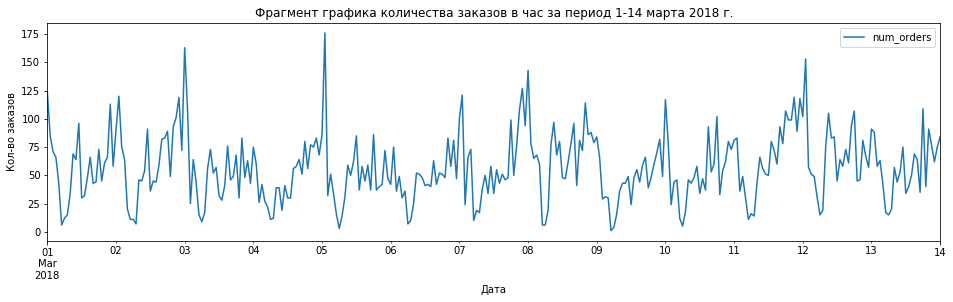

In [5]:
ax = df_resampled['2018-03-01 00:00:00':'2018-03-14 00:00:00'].plot(figsize=(16,4), title = 'Фрагмент графика количества заказов в час за период 1-14 марта 2018 г.')
ax.set(xlabel = 'Дата')
ax.set(ylabel = 'Кол-во заказов')

[Text(0, 0.5, 'Кол-во заказов')]

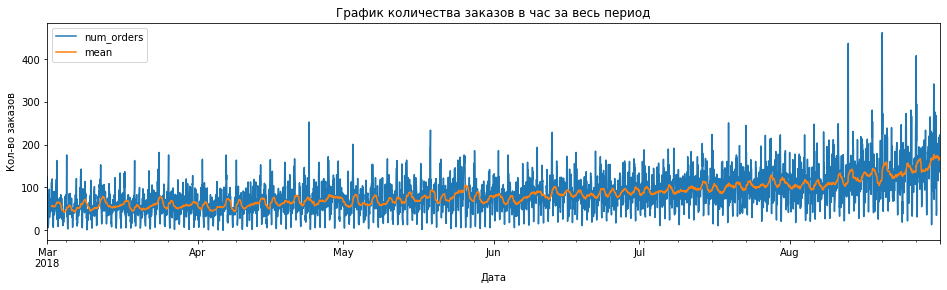

In [6]:
df_resampled['mean'] = df_resampled['num_orders'].rolling(24).mean()
ax = df_resampled.plot(figsize=(16,4), title = 'График количества заказов в час за весь период')
ax.set(xlabel = 'Дата')
ax.set(ylabel = 'Кол-во заказов')

**Наблюдения:** 
1. Наглядно видна суточная сезонность и внутрисуточные тренды
2. Временной ряд даже визуально не выглядит стационарным. 

**Выводы:** 
1. Из исходного ряда необходимо вычесть тренд и после этого проверить на стационарность

## 3.3. Обработка данных и оценка результата
<a id="3.3."></a>

In [7]:
df_resampled_diff = df_resampled.diff(periods=1).dropna()

[Text(0, 0.5, 'Кол-во заказов')]

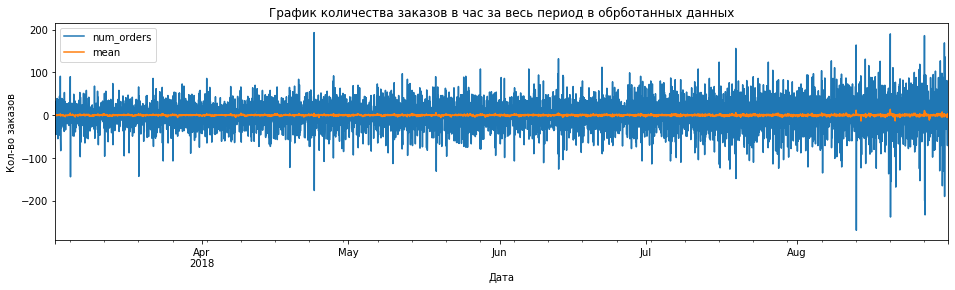

In [8]:
ax = df_resampled_diff.plot(figsize=(16,4), title = 'График количества заказов в час за весь период в обрботанных данных')
ax.set(xlabel = 'Дата')
ax.set(ylabel = 'Кол-во заказов')

**Проведем расширенный тест Дики — Фуллера ADF (Augmented Dickey Fuller)**

In [9]:
# Определяем функцию для теста ADF
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used']) 
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf 
adf_test(df_resampled_diff['num_orders'])

Results of Dickey-Fuller Test:
Test Statistic                -1.575169e+01
p-value                        1.221155e-28
#Lags Used                     3.100000e+01
Number of Observations Used    4.360000e+03
Critical Value (1%)           -3.431851e+00
Critical Value (5%)           -2.862203e+00
Critical Value (10%)          -2.567123e+00
dtype: float64


**Выводы:** 
1. Визуально ряд стал стационарным. 
2. p-value исчезающе мал, соответственно, тест Дики-Фуллера на стационарность считаем пройденным

## 3.4. Оценка трендов и сезонности
<a id="3.4."></a>

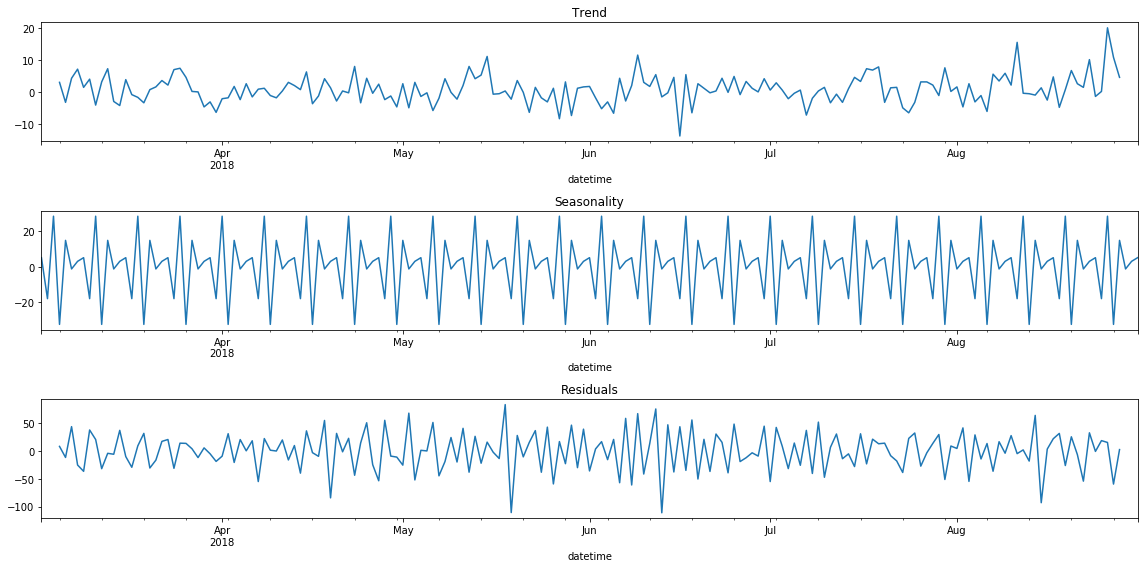

In [10]:
df_resampled_diff_resampled = df_resampled_diff.resample('1D').sum()

decomposed = seasonal_decompose(df_resampled_diff_resampled['num_orders']) 

plt.figure(figsize=(16, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

При повторном ресемплировании с шагом в 1 день отчетливо видна недельная сезонность, но не очень различм тренд. Попробуем изменить шаг ресемлирования и еще раз взглянуть на тренд

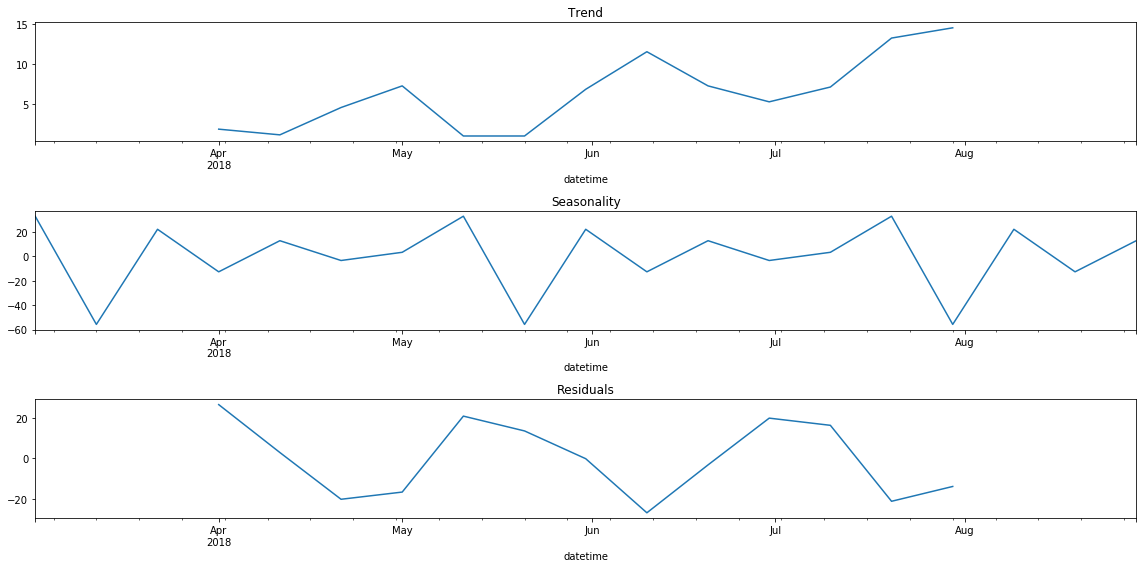

In [11]:
df_resampled_diff_resampled = df_resampled_diff.resample('10D').sum()

decomposed = seasonal_decompose(df_resampled_diff_resampled['num_orders']) 

plt.figure(figsize=(16, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

При повторном ресемплировании с шагом в 10 дней недельная сезонность перестала быть видна, но стал различм тренд.

## 3.5. Генерация признаков
<a id="3.5."></a>

In [12]:
df_resampled = df_resampled.drop(columns = 'mean')
display(df_resampled.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Подготовим функцию, которую будем использовать для генерации параметров и поиска наилучшего их значения

In [13]:
def generate_features(data, max_lag, rolling_mean_size, col_name, convert_params_to_cat=False):
    """
    Данная функция генерирует фичи для временного ряда для заданного столбца (col_name) 
    в соответствии с заданным значением максимального лага (max_lag) и скользящего среднего (rolling_mean_size). 
    И, если необходимо сконвериторовать в категориальный тип столбцы 'year', 'month', 'day', 'dayofweek', 'hour', 
    т.е. если convert_params_to_cat=True, то функция выполняет это преобразование. Это необходимо для обучения LightGBM.
    """
    data = data.copy()
    cat_params_list = ['dayofweek', 'hour']
    #data[cat_params_list[0]] = data.index.year
    #data[cat_params_list[1]] = data.index.month
    #data[cat_params_list[2]] = data.index.day
    data[cat_params_list[0]] = data.index.dayofweek
    data[cat_params_list[1]] = data.index.hour # возможно удалить
    
    if convert_params_to_cat:
        for feature in cat_params_list:
            data[feature] = data[feature].astype('category')
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[col_name].shift(lag)
    # посчитали скользящее среднее
    data['rolling_mean'] = data[col_name].rolling(rolling_mean_size).mean()
    # и опустили его на строчку ниже
    data['rolling_mean'] = data['rolling_mean'].shift()
    data = data.dropna()
    return data

# 4. Машинное обучение
<a id="4."></a>

Подготовим тестовую выборку и трировочную с валидационной.

In [14]:
df_train_valid, df_test = train_test_split(df_resampled, shuffle = False, test_size = 0.1)
print(df_train_valid.shape)
print(df_test.shape)

(3974, 1)
(442, 1)


## 4.1. Линейная регрессия
<a id="4.1."></a>

## 4.1.1. Обучение
<a id="4.1.1."></a>

Подготовим функцию для вычисления rmse по тестовым и тренировочным фичам и целевым признакам.

In [15]:
def fit_predict_linear_regression(X_train, X_valid, y_train, y_valid):
    """
    Данная функция обучает линейную регрессию, прогнозирует на валидационной выборке и вычисляет значение rmse
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    return mean_squared_error(y_valid, prediction, squared = False), model

подберем наилучшее сочетание значений max_lag и rolling_mean_size

In [16]:
def best_params_searcher(best_model_searcher, df, max_lag_min, max_lag_max, rolling_mean_size_min, 
                         rolling_mean_size_max, convert_params_to_cat = False):
    """
    Данная функция принимает на вход функцию поиска лучших гиперпарметров для произвольной модели, временной ряд, 
    диапазон в которых будет искаться наилучшие значения лага и скользящего среднего, 
    а также булев параметр "конвертировать в категориальные фичи"  (convert_params_to_cat).
    Функция находит наилучшее сочетание параметров max_lag (максимальный лаг) и rolling_mean_size (размер скользящего среднего). 
    На выходе функция возвращает лучшие значения и лучшую обученную модель.
    Значение параметра convert_params_to_cat функция передает во вложенную функцию генерации фич (generate_features), 
    которая в зависимости от полученного значения или преобразует категорияльные параметры в тип категориальных или нет
    """
    best_rmse = 1000
    for max_lag in range(max_lag_min, max_lag_max):
        for rolling_mean_size in range(rolling_mean_size_min, rolling_mean_size_max):
            df_with_features = generate_features(df, max_lag, rolling_mean_size, 'num_orders', convert_params_to_cat)
            X_train, X_valid, y_train, y_valid = train_test_split(df_with_features.drop('num_orders', axis = 1),
                                                        df_with_features['num_orders'],
                                                        shuffle = False, test_size = 0.1)
            rmse, model = best_model_searcher(X_train=X_train, X_valid=X_valid, y_train=y_train, y_valid=y_valid)

            if rmse < best_rmse:
                best_rmse = rmse
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
                best_model = model
                best_features_amount = X_train.shape[1]
    return best_rmse, best_max_lag, best_rolling_mean_size, best_model, best_features_amount      

Запустим best_params_searcher и подберем наилучшие параметры лага и скользящего среднего

In [17]:
best_rmse, best_max_lag, best_rolling_mean_size, best_model, best_features_amount =\
best_params_searcher(best_model_searcher = fit_predict_linear_regression, 
                     df = df_train_valid, 
                     max_lag_min = 1, 
                     max_lag_max = 25, 
                     rolling_mean_size_min = 1, 
                     rolling_mean_size_max = 25)

print(f'best_rmse = {best_rmse}, best_max_lag = {best_max_lag}, \
best_rolling_mean_size = {best_rolling_mean_size}, best_features_amount = {best_features_amount}') 

best_rmse = 34.32454864721255, best_max_lag = 24, best_rolling_mean_size = 22, best_features_amount = 27


## 4.1.2. Прогноз на тестовой выборке
<a id="4.1.2."></a>

Отлично, параметры нашли, теперь сгенерим фичи для отложенной тестовой выборки 

In [18]:
df_test_with_features = generate_features(df_test, best_max_lag, 
                                          best_rolling_mean_size, 
                                          'num_orders', 
                                          convert_params_to_cat=False)
df_test_with_features.shape

(418, 28)

Подготовим фичи и целвой признак

In [19]:
X_test = df_test_with_features.drop('num_orders', axis = 1)
y_test = df_test_with_features['num_orders']
print('X_test.shape =', X_test.shape)
print('y_test.shape =', y_test.shape)

X_test.shape = (418, 27)
y_test.shape = (418,)


А теперь посчитаем rmse на тестовой выборке

In [20]:
prediction = best_model.predict(X_test)
print('rmse на тестовой выборке = ', mean_squared_error(y_test, prediction, squared = False))

rmse на тестовой выборке =  45.428301711304954


Наложим на одном графике спрогнозированное и истенное значение

[Text(0, 0.5, 'Кол-во заказов')]

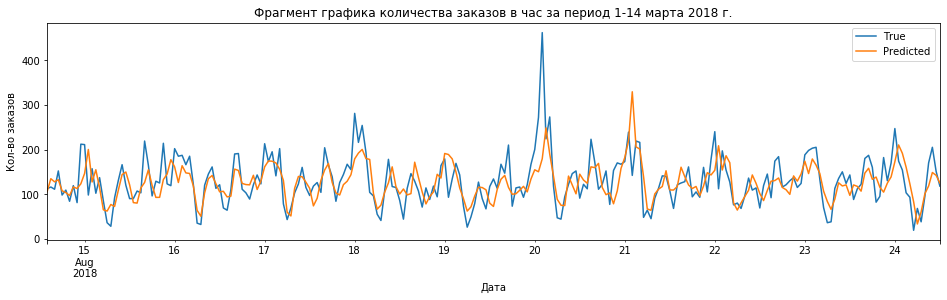

In [21]:
df_y_test_and_predicted = pd.DataFrame(y_test)
df_y_test_and_predicted['predicted'] = prediction

ax = df_y_test_and_predicted['2018-08-14 12:00:00':'2018-08-24 12:00:00']\
.rename(columns={'num_orders':'True', 'predicted':'Predicted'})\
.plot(figsize = (16,4),title = 'Фрагмент графика количества заказов в час за период 1-14 марта 2018 г.')

ax.set(xlabel = 'Дата')
ax.set(ylabel = 'Кол-во заказов')

"Штош".. не плохо, не плохо... визуально так же видно, что прогноз достаточо точен.

## 4.2. Градиентный бустинг. LightGBM
<a id="4.2."></a>

## 4.2.1. Обучение
<a id="4.2.1."></a>

In [22]:
# отключим ворнинги
warnings.filterwarnings('ignore')

Подготовим функцию для обучения градиентного бустинга

In [23]:
def fit_predict_lgbm(X_train, X_valid, y_train, y_valid):
    """
    Данная функция с помощью кроссвалидации для временных рядов обучает градиентный бустинг на тренировочной выборке 
    и с использованием лучших гиперпараметров вычисляет значение rmse на валидационной выборке.
    На выходе функция возвращает значение rmse и модель с лучшими гиперпараметрами
    """
    lgb = LGBMRegressor()
    tscv = TimeSeriesSplit()
    
    param_distributions_lgb_optuna = {
        'n_estimators': optuna.distributions.IntUniformDistribution(10,1000,10)
        ,'max_depth': optuna.distributions.IntUniformDistribution(2,40,1) #
        ,'learning_rate': optuna.distributions.LogUniformDistribution(0.5e-1,1e-1) # #CategoricalDistribution([0.003, 0.005, 0.01, 0.05, 0.1 ]) #.CategoricalDistribution([0.003, 0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.1 ]) #IntUniformDistribution(0.02, 0.1, 0.01)
        }
    opt_search_lgb = optuna.integration.OptunaSearchCV(lgb, param_distributions_lgb_optuna, cv=tscv, 
                                                       n_trials=100,
                                                       scoring='neg_root_mean_squared_error',
                                                       timeout=600,
                                                       random_state=42)
    
    opt_search_lgb.fit(X_train, y_train)
    opt_search_prediction = opt_search_lgb.best_estimator_.predict(X_valid)
    opt_search_prediction_score = mean_squared_error(y_valid, opt_search_prediction, squared=False)
    
    return opt_search_prediction_score, opt_search_lgb.best_estimator_

и снова восльзуемся функцией best_params_searcher, но на этот в качестве предсказателя на входе зададим LightGBM и применим ранее найденные для линейной регрессии лучшие значения лага и скользящего среднего. 

Прим: Поиск более лучших значений в диапазоне от "best_max_lag - 7" до "best_max_lag + 1" и "best_rolling_mean_size - 7" до "best_rolling_mean_size + 1" лучше результата не дал

In [24]:
%%time
best_rmse, best_max_lag, best_rolling_mean_size, best_model, best_features_amount =\
best_params_searcher(best_model_searcher = fit_predict_lgbm, 
                     df = df_train_valid, 
                     max_lag_min = best_max_lag, 
                     max_lag_max = best_max_lag+1, 
                     rolling_mean_size_min = best_rolling_mean_size, 
                     rolling_mean_size_max = best_rolling_mean_size+1,
                     convert_params_to_cat=True) # не забываем конвертировать параметры в категориальные

print(f'best_rmse = {best_rmse}, best_max_lag = {best_max_lag}, \
best_rolling_mean_size = {best_rolling_mean_size}, best_features_amount = {best_features_amount}') 

[I 2022-07-20 18:25:16,356] A new study created in memory with name: no-name-3732b5c6-35b4-49aa-b501-e0249737c749
[I 2022-07-20 18:25:22,265] Trial 0 finished with value: -23.899820497625655 and parameters: {'n_estimators': 460, 'max_depth': 34, 'learning_rate': 0.052451332919674014}. Best is trial 0 with value: -23.899820497625655.
[I 2022-07-20 18:25:26,458] Trial 1 finished with value: -23.90464126530648 and parameters: {'n_estimators': 320, 'max_depth': 20, 'learning_rate': 0.06148309225172415}. Best is trial 0 with value: -23.899820497625655.
[I 2022-07-20 18:25:28,552] Trial 2 finished with value: -23.77709198881679 and parameters: {'n_estimators': 220, 'max_depth': 8, 'learning_rate': 0.056496026444092226}. Best is trial 2 with value: -23.77709198881679.
[I 2022-07-20 18:25:32,448] Trial 3 finished with value: -24.1634450081387 and parameters: {'n_estimators': 320, 'max_depth': 15, 'learning_rate': 0.09994808707511323}. Best is trial 2 with value: -23.77709198881679.
[I 2022-07-

[I 2022-07-20 18:28:19,601] Trial 35 finished with value: -23.929207005402915 and parameters: {'n_estimators': 920, 'max_depth': 4, 'learning_rate': 0.061778901972392185}. Best is trial 16 with value: -23.67677508547059.
[I 2022-07-20 18:28:26,324] Trial 36 finished with value: -23.854630457037143 and parameters: {'n_estimators': 740, 'max_depth': 9, 'learning_rate': 0.05799643247158519}. Best is trial 16 with value: -23.67677508547059.
[I 2022-07-20 18:28:30,127] Trial 37 finished with value: -23.908041308431283 and parameters: {'n_estimators': 330, 'max_depth': 30, 'learning_rate': 0.05453761596012151}. Best is trial 16 with value: -23.67677508547059.
[I 2022-07-20 18:28:39,636] Trial 38 finished with value: -23.94703062736728 and parameters: {'n_estimators': 860, 'max_depth': 14, 'learning_rate': 0.05283718354084932}. Best is trial 16 with value: -23.67677508547059.
[I 2022-07-20 18:28:47,741] Trial 39 finished with value: -23.935071950330247 and parameters: {'n_estimators': 790, 'm

[I 2022-07-20 18:30:43,418] Trial 71 finished with value: -23.733622470885678 and parameters: {'n_estimators': 770, 'max_depth': 2, 'learning_rate': 0.05703772585844216}. Best is trial 51 with value: -23.63238880130657.
[I 2022-07-20 18:30:44,888] Trial 72 finished with value: -23.732472858630082 and parameters: {'n_estimators': 760, 'max_depth': 2, 'learning_rate': 0.055194750339806316}. Best is trial 51 with value: -23.63238880130657.
[I 2022-07-20 18:30:48,072] Trial 73 finished with value: -23.95126435171083 and parameters: {'n_estimators': 840, 'max_depth': 4, 'learning_rate': 0.05953545391928288}. Best is trial 51 with value: -23.63238880130657.
[I 2022-07-20 18:30:50,264] Trial 74 finished with value: -23.97570136359912 and parameters: {'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.054042859984362465}. Best is trial 51 with value: -23.63238880130657.
[I 2022-07-20 18:30:54,188] Trial 75 finished with value: -23.878952248203017 and parameters: {'n_estimators': 750, 'max

best_rmse = 31.00117671210922, best_max_lag = 24, best_rolling_mean_size = 22, best_features_amount = 27
Wall time: 6min 32s


## 4.2.2. Прогноз на тестовой выборке
<a id="4.2.2."></a>

In [25]:
df_test_with_features = generate_features(df_test, best_max_lag, 
                                          best_rolling_mean_size, 
                                          'num_orders', 
                                          convert_params_to_cat=True)
df_test_with_features.shape

(418, 28)

Подготовим фичи и целвой признак

In [26]:
X_test = df_test_with_features.drop('num_orders', axis = 1)
y_test = df_test_with_features['num_orders']
print('X_test.shape =', X_test.shape)
print('y_test.shape =', y_test.shape)

X_test.shape = (418, 27)
y_test.shape = (418,)


А теперь посчитаем rmse на тестовой выборке

In [27]:
prediction = best_model.predict(X_test)
print('rmse На тестовой выборке = ', mean_squared_error(y_test, prediction, squared = False))

rmse На тестовой выборке =  51.215060938404704


Наложим на одном графике спрогнозированное и истенное значение

[Text(0, 0.5, 'Кол-во заказов')]

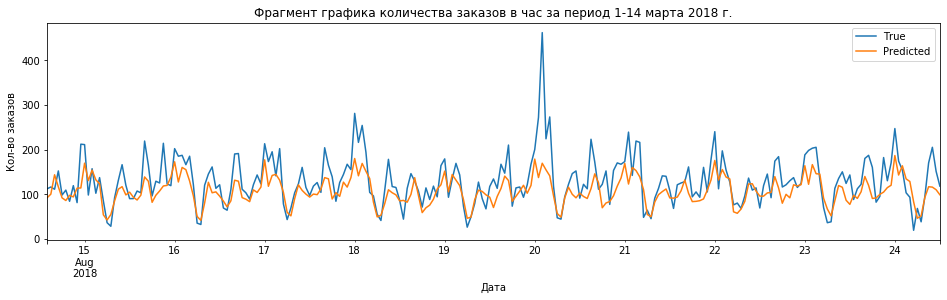

In [28]:
df_y_test_and_predicted = pd.DataFrame(y_test)
df_y_test_and_predicted['predicted'] = prediction

ax = df_y_test_and_predicted['2018-08-14 12:00:00':'2018-08-24 12:00:00']\
.rename(columns={'num_orders':'True', 'predicted':'Predicted'})\
.plot(figsize = (16,4),title = 'Фрагмент графика количества заказов в час за период 1-14 марта 2018 г.')

ax.set(xlabel = 'Дата')
ax.set(ylabel = 'Кол-во заказов')

## 5. Выводы
<a id="5."></a>

В рамках настоящего проекта были проведены

- Ресемплирование (до шага в 1 ч)
- Предварительный анализ данных. Были обнапружены суточная сезонность и внутрисуточные тренды. Было принято решение вычесть тренд и провести тест на стационарность.
- Обработка данных и оценка результата. Было проведено вычитание тренда и после этого проведен и успешно пройден тест Дики-Фуллера на стационарность, что позволило нам выполнять дальнейшие манипуляции с временным рядом и иметь возможность прогнозировать его.
 - Проведена последующая оценка трендов и сезонности
    
После чего были подготовлены функции для генерация признаков, поиска наилучшего сочетания сгенерированных признаков и проведено машинное обучение с оценкой сперва на валидационных данных, а затем на отложенной тестовой выборке. Размер валидационной и тестовой выборок был взят в размере 10% на каждом этапе деления.

Машинное обучение было проведено с использованием двух моделей: Линейная регрессия и градиентный бустинг на базе LightGBM. 
Линейная регрессия достигла требуемого порога (rmse = 45), а градиентный бустинг при прочих равных не  справился с задачей (rmse = 51).  

В качестве возможных последующих действий (за рамками настоящего проекта) можно предположить, что помогут улучшить результат следующие действия:
1. Выполнить OHE для датасета для линейной регресии
2. Использовать другие линейные модели, с возможностью настройки регуляризации